In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-beat-classification/AbnormalHeartbeat.png
/kaggle/input/heart-beat-classification/AbnormalHeartbeat.txt
/kaggle/input/heart-beat-classification/AbnormalHeartbeat.pdf
/kaggle/input/heart-beat-classification/AbnormalHeartbeat.arff
/kaggle/input/heart-beat-classification/AbnormalHeartbeat_TRAIN.ts
/kaggle/input/heart-beat-classification/AbnormalHeartbeat_TRAIN.arff
/kaggle/input/heart-beat-classification/AbnormalHeartbeat_TEST.arff
/kaggle/input/heart-beat-classification/AbnormalHeartbeat_TEST.ts


Ukoly
1. Prevest data do pandas dataframu
    1. Data jsou ve formatu arff 
2. Navrhnout model a vyhodnotim model

In [2]:
from scipy.io import arff
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
path_arff_train = "/kaggle/input/heart-beat-classification/AbnormalHeartbeat_TRAIN.arff"
path_ts_train = "/kaggle/input/heart-beat-classification/AbnormalHeartbeat_TRAIN.ts"
path_arff_test = "/kaggle/input/heart-beat-classification/AbnormalHeartbeat_TEST.arff"
path_ts_test = "/kaggle/input/heart-beat-classification/AbnormalHeartbeat_TEST.ts"

In [4]:
data_arff_train = arff.loadarff(path_arff_train)
data_arff_test = arff.loadarff(path_arff_test)

Inspekce dat

Data jsou ve formatu arff. Pro pouziti je nutne je nejprve prevest do numpy pole, ktere je nasledne prevedeno do pandas dataframu.
data_arff_train jsou ve formatu touple kde, index 0 obsahuje data a index 1 obsahuje metadata *scipy.io.arff.arffread.MetaData*. Meta data rikaji jakeho typu jsou jednotlive zaznamy. 

Podle zadani maji data frekvenci 4KHz.

In [5]:
data_train = pd.DataFrame(data_arff_train[0])
X_train = data_train.iloc[:, :-1]
y_train = data_train.target
data_test = pd.DataFrame(data_arff_test[0])
X_test = data_test.iloc[:, :-1]
y_test = data_test.target

In [6]:
#X_test.head()
X_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att18521,att18522,att18523,att18524,att18525,att18526,att18527,att18528,att18529,att18530
0,-0.020874,-0.045197,-0.043945,-0.049011,-0.046600,-0.048004,-0.045563,-0.041962,-0.037170,-0.029541,...,-0.043823,-0.044037,-0.041382,-0.040192,-0.036194,-0.034424,-0.032532,-0.032501,-0.031982,-0.033783
1,-0.004303,-0.009003,-0.008728,-0.009918,-0.009949,-0.010681,-0.010773,-0.011200,-0.011230,-0.011169,...,0.017975,0.016815,0.016846,0.016754,0.015839,0.015930,0.015961,0.016205,0.016357,0.017792
2,-0.006073,-0.012054,-0.009979,-0.010742,-0.009888,-0.010406,-0.010101,-0.009979,-0.010162,-0.010315,...,-0.013763,-0.006775,0.001740,0.010071,0.017914,0.025574,0.032959,0.039673,0.044739,0.050018
3,0.007202,0.015594,0.013245,0.015594,0.015015,0.017792,0.018250,0.020660,0.021240,0.022797,...,0.042511,0.040466,0.037994,0.036011,0.033295,0.032074,0.030304,0.030426,0.030212,0.031219
4,-0.024231,-0.051056,-0.045929,-0.049835,-0.048828,-0.049316,-0.048401,-0.047913,-0.046051,-0.045837,...,-0.256348,-0.277618,-0.294800,-0.303314,-0.309082,-0.314179,-0.310944,-0.304504,-0.298065,-0.282532


# PyTorch kod

In [7]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = y_train.apply(lambda x: 1 if x == b'Abnormal' else 0)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = y_test.apply(lambda x: 1 if x == b'Abnormal' else 0)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [8]:
class my_dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return len(self.X)

In [9]:
train_dataset = my_dataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=51, shuffle=True)
test_dataset = my_dataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=45, shuffle=False)

In [10]:
x, y = next(iter(test_dataloader))
print(y)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.])


Prehled dat

In [12]:
x, targets = next(iter(train_dataloader))
print(x[0], targets[0])

tensor([ 0.0022,  0.0023,  0.0007,  ..., -0.0262, -0.0328, -0.0404]) tensor(1.)


In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18530, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
    

In [14]:
    learning_rate = 1e-9
    batch_size = 8
    epochs = 100

    model = Model()
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [56]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    TP = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        y = y.view(-1, 1)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss.item()
#train_loop(train_dataloader, model, loss_fn, optimizer)

tensor(51)
tensor(102)
tensor(153)
tensor(204)


0.6848838925361633

In [27]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.view(-1, 1)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = (pred >= 0.5).type(torch.float)
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct
#test_loop(test_dataloader, model, loss_fn)

Training model loop

In [ ]:
train_metrics = {'epochs': [], 'loss': []}
test_metrics = {'epochs': [], 'loss': [], 'accuracy': []}

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    te_loss, te_acc = test_loop(test_dataloader, model, loss_fn)
    
    train_metrics['epochs'].append(t)
    test_metrics['epochs'].append(t)
    train_metrics['loss'].append(tr_loss)
    test_metrics['loss'].append(te_loss)
    test_metrics['accuracy'].append(te_acc)
print("Done!")


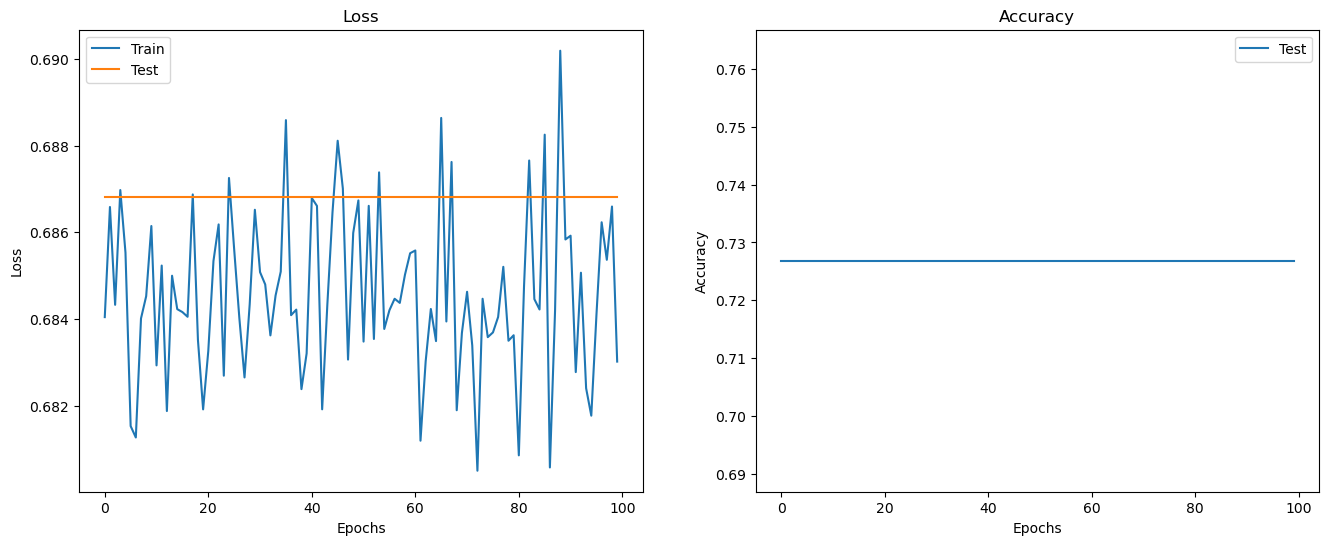

In [47]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

ax[0].plot(train_metrics['epochs'], train_metrics['loss'], label="Train")
ax[0].plot(test_metrics['epochs'], test_metrics['loss'], label="Test")
ax[1].plot(test_metrics['epochs'], test_metrics['accuracy'], label="Test")

ax[0].legend()
ax[1].legend()
plt.show()